# Spatial relatedness analysis

This notebook analyses the spatial structure of IBD relatedness between samples from different areas and distances. 

We first import the required packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from genomic_tools.pairwise import high_ibd_frac_per_cat, show_ibd_frac_per_cat
from genomic_tools.pairwise import connectivity_map, mean_high_ibd_frac_vs_dist
import geopandas
from spatial_tools import clustering
from stat_tools import glm
import contextily as ctx
from matplotlib import cm

## Importing data

We now load the data to be used:

In [2]:
#Metadata
pipeline_results_path  = "/home/apujol/isglobal/manuscripts/importation_relatedness/data/"
all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')
#Select relevant variables
metadata = all_data_div_covered_samples[['sampleID', 'nida', 'study', 'run_id_resmark', 'year', \
                                         'region', 'province', 'district', \
                                         'us', 'age', 'sex', 'parasitemia', \
                                         '1.2 Selecione o distrito do estudo.',
                                         'date', '3.2 Data da Notificação.', \
                                         'occupation', \
                                         'travel', 'travel_prov', 'travel_dist', \
                                         'Data de Ida.', 'Data de regresso', \
                                         'latitude', 'longitude', 'travel_days', \
                                         'travel_days_728', 'source']].drop_duplicates()

#Fix inconsistent values from some variables 
metadata.loc[metadata['district'].isnull(), 'district'] = metadata.loc[metadata['district'].isnull(), '1.2 Selecione o distrito do estudo.']
metadata.loc[metadata['province'] == 'Maputo Provincia', 'province'] = 'Maputo'
metadata.loc[metadata['province'] == 'Maputo Cidade', 'province'] = 'Maputo City'
#Make data a temporal variable
metadata['date'] = pd.to_datetime(metadata['date'])

/tmp/ipykernel_33178/1154629623.py:3: DtypeWarning: Columns (12,13,15,18,19,22,24,25,28,29,30,31,32,33,34,35,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')


## Loading IBD results

We load the IBD results obtained from Dcifer:

In [3]:
#Path where the results are stored
ibd_data_path = pipeline_results_path
#Load results
ibd_res_filename = ibd_data_path + "ibd_results.csv"
ibd_res = pd.read_csv(ibd_res_filename)
ibd_pval_filename = ibd_data_path + "ibd_results_p_value.csv"
ibd_pval = pd.read_csv(ibd_pval_filename)
ibd_res.index = ibd_res.columns
ibd_pval.index = ibd_pval.columns

## Visualise IBD results

`ibd_res` and `ibd_pval` variables contain a 2D-matrix of the pairwise results of IBD and their p-value (under the hypothesis that IBD=0). As an example, we visualise a 50x50 part of the matrix, representing the pairwise results of 50 samples. One half of the matrix is empty to avoid redundance in the results. In the first matrix, IBD results are shown, with some transparency for those results with p<0.05. 

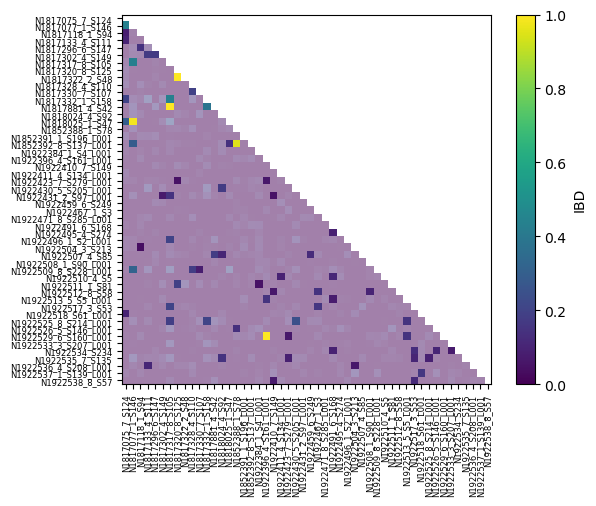

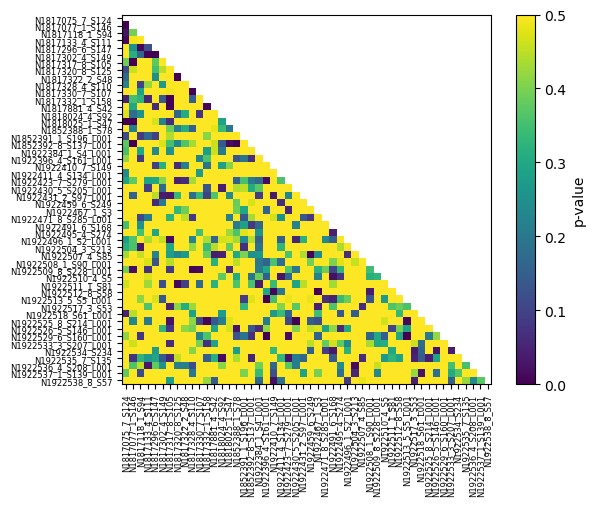

In [4]:
#Visualising pairwise IBD results
i, j = 0, 50
plt.imshow(np.array(ibd_res.iloc[i:j,i:j]), alpha = .5 + .5*np.array(np.array(ibd_pval.iloc[i:j,i:j]) < .05, dtype = float))
plt.yticks(np.arange(len(ibd_res.iloc[i:j,i:j])), ibd_res.iloc[i:j,i:j].index, fontsize = 6)
plt.xticks(np.arange(len(ibd_res.iloc[i:j,i:j])), ibd_res.iloc[i:j,i:j].index, rotation = 90, fontsize = 6)
plt.colorbar(label = 'IBD')
plt.show()

#Visualising the p-values of these IBD results
plt.imshow(np.array(ibd_pval.iloc[i:j,i:j]))
plt.yticks(np.arange(len(ibd_pval.iloc[i:j,i:j])), ibd_pval.iloc[i:j,i:j].index, fontsize = 6)
plt.xticks(np.arange(len(ibd_pval.iloc[i:j,i:j])), ibd_pval.iloc[i:j,i:j].index, rotation = 90, fontsize = 6)
plt.colorbar(label = r'p-value')
plt.show()

### Adding metadata and GPS locations

Here we merge the IBD results with the metadata: 

In [5]:
ibd_res_meta = pd.merge(ibd_res, metadata, left_index = True, right_on = 'sampleID', how = 'left')
ibd_pval_meta = pd.merge(ibd_pval, metadata, left_index = True, right_on = 'sampleID', how = 'left')

We merge the GPS location of samples. We do it in a higherarchical way, so that the GPS location of the sample province is used as a proxy for their GPS location, taking a representative health facility as a reference. Then, when available, the GPS of the health facility is also used as a refined proxy of their location. Finally, the household GPS is used as the true location when available. 

In [6]:
#We define the GPS location of the provinces
list_locs = {
    'Maputo' : [32.64216410, -25.02049992], #Magude
    'Maputo City' : [32.576388888888889, -25.915277666666],
    'Magude' : [32.64216410, -25.02049992], 
    'Massinga' : [35.37405260,-23.32666250], 
    'Gaza' : [34.19153, -24.9206],#Chidenguele HF
    'Inhambane' : [35.38, -23.33456],#Massinga
    'Zambezia' : [35.71279, -17.97899],#Mopeia
    'Cabo Delgado' : [38.99972150, -13.12555980],#Montepuez
    'Tete' : [33.618156, -16.138187],#Tete
    'Sofala' : [34.846280, -19.833158],#Beira
    'Niassa' : [36.36631, -14.9154], #Cuamba Titimane
    'Manica' : [33.34914, -17.41963], #Guro sede
    'Nampula' : [39.26173, -15.123], #Hospital Geral de Nampula distrito
    }
locations = pd.DataFrame({'location' : [i for i in list_locs], 'longitude': [list_locs[i][0] for i in list_locs], 'latitude': [list_locs[i][1] for i in list_locs]})
locations = geopandas.GeoDataFrame(locations, geometry = geopandas.points_from_xy(locations['longitude'], locations['latitude']))
locations = locations.set_crs(epsg=4326)

list_provs = {}
for prov in ['Maputo', 'Maputo City', 'Inhambane', \
              'Manica', 'Sofala', 'Tete', 'Zambezia', \
               'Nampula', 'Niassa', 'Cabo Delgado']:
    list_provs[prov] = list_locs[prov]

provinces = pd.DataFrame({'location' : [i for i in list_provs], 'longitude': [list_provs[i][0] for i in list_provs], 'latitude': [list_provs[i][1] for i in list_provs]})
provinces = geopandas.GeoDataFrame(provinces, geometry = geopandas.points_from_xy(provinces['longitude'], provinces['latitude']))
provinces = provinces.set_crs(epsg=4326)

In [7]:
#Merging GPS location of provinces
ibd_res_meta = pd.merge(ibd_res_meta, provinces[['location', 'longitude', 'latitude']], \
         left_on = 'province', right_on = 'location', how = 'left')
ibd_res_meta = ibd_res_meta.rename(columns = {'longitude_x' : 'longitude', \
                                             'latitude_x' : 'latitude', \
                                             'longitude_y' : 'longitude_prov', \
                                             'latitude_y' : 'latitude_prov'})
ibd_pval_meta['longitude_prov'] = ibd_res_meta['longitude_prov']
ibd_pval_meta['latitude_prov'] = ibd_res_meta['latitude_prov']

In [8]:
def clean_name_end(text):
    """
    This method removes all the blank spaces at 
    the end of a text. 
    
    Parameters:
    -----------
    text: str
        String to clean.
        
    Returns:
    --------
    text: str
        Cleaned string.
    
    """
    while text[-1] == ' ':
        text = text[:-1]
    return text

In [9]:
#Merging GPS location of health facilities

#Loading HF data
hf_datapath = "/home/apujol/isglobal/manuscripts/importation_relatedness/data/"
all_filename = hf_datapath + 'Coordenadas das US no Pais 2018.xlsx'
hf_data = pd.read_excel(all_filename, usecols = 'B:I', skiprows = 1)
#Masking invalid data
mask = hf_data['Latitude'] != '----------'
#Generating geopandas DataFrame with GPS locations of the health facilities
hf_data = geopandas.GeoDataFrame(hf_data[mask], geometry = geopandas.points_from_xy(hf_data[mask].Longitude, hf_data[mask].Latitude), \
                             crs="EPSG:4326")
#clean names of health facilities for consistency across tables
for i in hf_data.index:
    hf_data.loc[i, 'Nome da US'] = clean_name_end(hf_data.loc[i, 'Nome da US'])
    hf_data.loc[i, 'Província'] = clean_name_end(hf_data.loc[i, 'Província'])
    
#Renaming health facilities for consistency
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Boane', 'us'] = 'C.S. Boane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Panjane', 'us'] = 'C.S. Panjane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Gueveza', 'us'] = 'CS Gueveza'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Ponta de Ouro', 'us'] = 'CS Ponta do Ouro'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Nsime', 'us'] = 'CS Nsime'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Salamanga', 'us'] = 'CS Salamanga'
ibd_res_meta.loc[ibd_res_meta['us'] == 'c.s Nsime', 'us'] = 'CS Nsime'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Facazissa', 'us'] = 'CS Facazissa'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Mapulanguene', 'us'] = 'CS Mapulanguene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Chicutso', 'us'] = 'CS Chicutso'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Captine', 'us'] = 'CS Captine'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S.Matutuine', 'us'] = 'CS Matutuine'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Matutuine', 'us'] = 'CS Matutuine'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Manhangane', 'us'] = 'CS Manhangane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Catuane', 'us'] = 'CS Catuane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Cuamba', 'us'] = 'C.S. Cuamba (CB)'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Guro sede', 'us'] = 'C.S. Guro'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Ratorga', 'us'] = 'C.S. Ratorga'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. de Massaca', 'us'] = 'BOANE CS Massaca'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Manhiça', 'us'] = 'C.S. Cuamba (CB)'
ibd_res_meta.loc[ibd_res_meta['us'] == 'IMALA', 'us'] = 'CS Imala'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MUTUALI', 'us'] = 'CS Mutuali'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MUTUALI ', 'us'] = 'CS Mutuali'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MECUBURI', 'us'] = 'CS Mecuburi'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MALEMA', 'us'] = 'CS Malema'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MECUBURI ', 'us'] = 'CS Mecuburi'
ibd_res_meta.loc[ibd_res_meta['us'] == 'NAMINA', 'us'] = 'CS Namina'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Nhamaxana', 'us'] = 'CS Nhamaxana'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Mopeia sede', 'us'] = 'CS Mopeia_Sede'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Gulamo', 'us'] = 'CS Gulamo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Lua lua', 'us'] = 'CS Lua_Lua'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Posto campo', 'us'] = 'CS Posto Campo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Cuguana', 'us'] = 'CS Cuguana'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Bembe', 'us'] = 'CS Bembe'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Agostinho Neto', 'us'] = 'CS Agostinho Neto'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Manhala', 'us'] = 'CS Manhala'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Maxixe', 'us'] = 'CS Maxixe'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Dambo', 'us'] = 'CS Dambo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mawewe', 'us'] = 'CS Mawewe'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mabil', 'us'] = 'CS Mabil'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Chiramba', 'us'] = 'CS Chiramba'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mulima', 'us'] = 'CS Mulima'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Cado', 'us'] = 'CS Cado'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Catulene', 'us'] = 'CS Catulene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Chemba Sede', 'us'] = 'CS Chemba_Sede'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Correia', 'us'] = 'CS Correia'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Macuamene', 'us'] = 'CS Macuamene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Malavela', 'us'] = 'CS Malavela'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Chamanculo', 'us'] = 'CS Chamanculo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Boane', 'us'] = 'CS Boane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Jequessene', 'us'] = 'CS Jequessene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Senhabuzua', 'us'] = 'CS Senhabuzua'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Goe', 'us'] = 'CS Goe'
ibd_res_meta.loc[ibd_res_meta['us'] == 'LALAUA', 'us'] = 'CS Lalaua'
ibd_res_meta.loc[ibd_res_meta['us'] == 'METI', 'us'] = 'CS Meti'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MUECATE', 'us'] = 'CS Muecate'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Napacala', 'us'] = 'CS Napacala'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mepessene', 'us'] = 'CS Mepessene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Cuamba (CB)', 'us'] = 'CS Cuamba'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Guro', 'us'] = 'CS Guro _ Sede'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Amatongas', 'us'] = 'CS Amatongas'
ibd_res_meta.loc[ibd_res_meta['us'] == 'H.D. Gondola', 'us'] = 'HD Gondola'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Ratorga', 'us'] = 'CS Ratorga'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Josina Machel', 'us'] = 'CS Josina Machel'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Nhansana', 'us'] = 'CS Nhansana'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Chivuli', 'us'] = 'CS Chivuli'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Tshecha', 'us'] = 'CS Tshecha'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mungari', 'us'] = 'CS Mungari'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mungano', 'us'] = 'CS Mungano'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Murrie', 'us'] = 'CS Murrie'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Rio de Pedras', 'us'] = 'CS Rio das Pedras'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Massinga Sede', 'us'] = 'HD Massinga'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Nhachenge', 'us'] = 'CS Nhachenge'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Manhala', 'us'] = 'CS de Manhala'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Malavela', 'us'] = 'CS malavela'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Chamanculo', 'us'] = 'HG Chamanculo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS 1 de Junho', 'us'] = 'CS 1º de Junho'

ibd_pval_meta['us'] = ibd_res_meta['us']

#merging HF locations
#masking HFs that have the same name as some from our data but from other provinces
mask = (hf_data['Nome da US'] == 'CS Malema')&(hf_data['Província'] == 'Zambezia')
mask = mask | (hf_data['Nome da US'] == 'CS Josina Machel')&(hf_data['Província'] == 'Nampula')
mask = mask | (hf_data['Nome da US'] == 'CS Josina Machel')&(hf_data['Província'] == 'Inhambane')
mask = np.invert(mask)
ibd_res_meta = pd.merge(ibd_res_meta, hf_data.loc[mask, ['Nome da US', 'Latitude', 'Longitude']].drop_duplicates(), \
         left_on = 'us', right_on = 'Nome da US', how = 'left')
ibd_res_meta = ibd_res_meta.rename(columns = {'Longitude' : 'longitude_us', \
                                             'Latitude' : 'latitude_us'})

ibd_pval_meta = pd.merge(ibd_pval_meta, hf_data.loc[mask, ['Nome da US', 'Latitude', 'Longitude']].drop_duplicates(), \
         left_on = 'us', right_on = 'Nome da US', how = 'left')
ibd_pval_meta = ibd_pval_meta.rename(columns = {'Longitude' : 'longitude_us', \
                                             'Latitude' : 'latitude_us'})

GPS locations from some of the health facilities were missing: 

In [10]:
ibd_res_meta[ibd_res_meta['latitude_us'].isnull()&ibd_res_meta['us'].notnull()]['us'].unique()

array(['CS Capitine', 'CS Nhamaxana', 'CS Catulene', 'CS Correia',
       'CS Boane', 'C.S. 25 de Junho', 'CS Jequessene', 'CS Amatongas',
       'CS Ratorga', 'CS Tshecha', 'CS Mungano', 'CS Murrie',
       'CS Nhachenge'], dtype=object)

## saving IBD results with metadata

We save the tables with both IBD (and p-value) results and metadata:

In [11]:
ibd_res_meta.to_csv(ibd_data_path + "ibd_results_with_metadata.csv")
ibd_pval_meta.to_csv(ibd_data_path + "ibd_results_p_value_with_metadata.csv")

## IBD results per province

In this section we estimate the fraction of related pairs across different populations (districts and provinces). For this, we use IBD and p-value thresholds to define related pairs. In the following cases, we used the thresholds of IBD>0.1 and p<0.05. 

In [12]:
save_path = "/home/apujol/isglobal/manuscripts/importation_relatedness/figs/"

Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


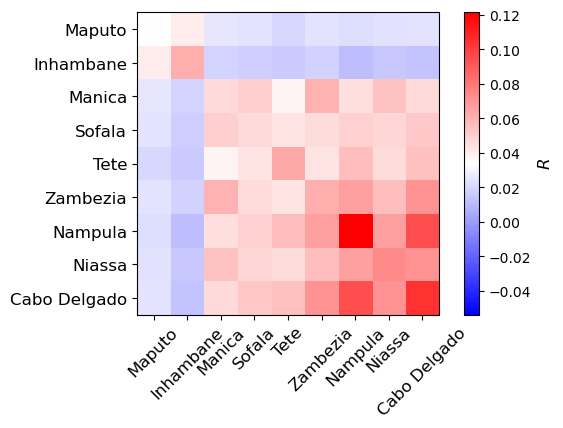

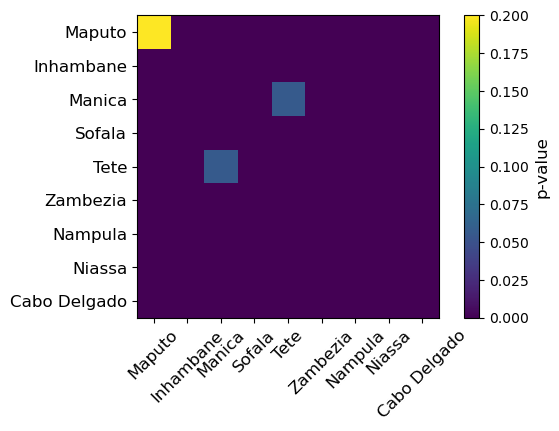

In [13]:
#Define category to define populations
category_label = 'province'
#List of populations used in this category
categories = ['Maputo', 'Inhambane', \
              'Manica', 'Sofala', 'Tete', 'Zambezia', \
               'Nampula', 'Niassa', 'Cabo Delgado']
#Definition of thresholds to define related pairs
max_p = .05
min_IBD = 0.1

#We calculate the fraction of related pairs across populations, their p-value of deviation with respect to the
#fraction overall paris, and the overall fraction. 
ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories, \
                                                                                     verbose = True, perm_pval = False)
#Parameters to define if we want to save the figure produced
save_as = None
#save_as = save_path + "ibd_provinces.pdf"
#Show the results
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, ibdfrac_pval_per_cat, min_IBD = min_IBD, max_p = max_p, \
                     save_as = save_as, cmap_label = r"$R$", subplot_adj=[None, None, None, .25])

With these results of IBD-relatedness across provinces, we produce the following map, where the width and colour of the lines and points are proportional to the genetic relatedness between their populations. 

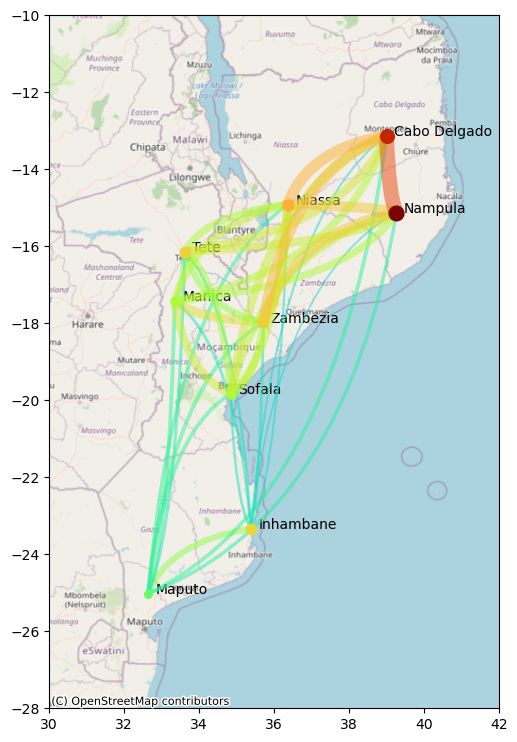

In [34]:
connectivity_map(ibdfrac_per_cat, categories, provinces, color = 'auto', linewidth = 'prop', print_locations=True)
#plt.savefig(save_path + "ibd_map_locs.pdf")
#plt.savefig(save_path + "ibd_map_locs.png")

Here we calculate the IBD-relatedness (as fraction of related pairs) across populations from the different districts of Maputo (Magude and Matutuine) and Inhambane (Maxixe and Massinga):

Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


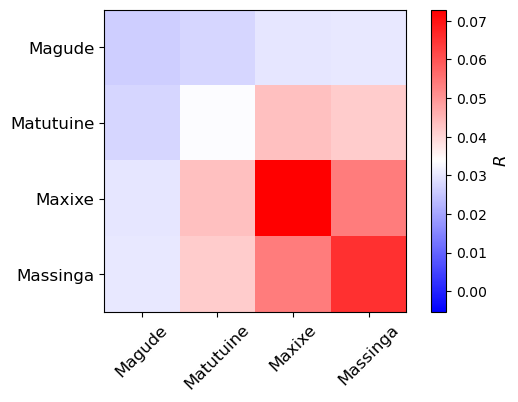

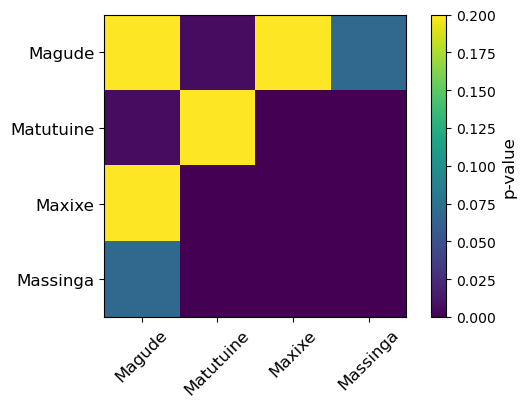

In [16]:
#Define category to define populations
category_label = 'district'
#List of populations used in this category
categories = ['Magude', 'Matutuine', 'Maxixe', \
              'Massinga']
#Definition of thresholds to define related pairs
max_p = .05
min_IBD = 0.1

#We calculate the fraction of related pairs across populations, their p-value of deviation with respect to the
#fraction overall paris, and the overall fraction.
ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories, \
                                                                                     verbose = True, perm_pval = False)
#Parameters to define if we want to save the figure produced
save_as = None
#save_as = save_path + "ibd_districts.png"
#Show the results
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, ibdfrac_pval_per_cat, min_IBD = min_IBD, max_p = max_p, \
                     save_as = save_as, cmap_label = r"$R$", subplot_adj=[None, None, None, .25])

And finally, we calculate IBD-relatedness across regions: 

In [17]:
#Define variable region
ibd_res_meta['region'] = pd.Series()
ibd_res_meta.loc[ibd_res_meta['province'] == 'Maputo City', 'region'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Maputo', 'region'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Inhambane', 'region'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Manica', 'region'] = 'Central'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Sofala', 'region'] = 'Central'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Tete', 'region'] = 'Central'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Zambezia', 'region'] = 'Central'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Nampula', 'region'] = 'North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Niassa', 'region'] = 'North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Cabo Delgado', 'region'] = 'North'
ibd_pval_meta['region'] = ibd_res_meta['region']

Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


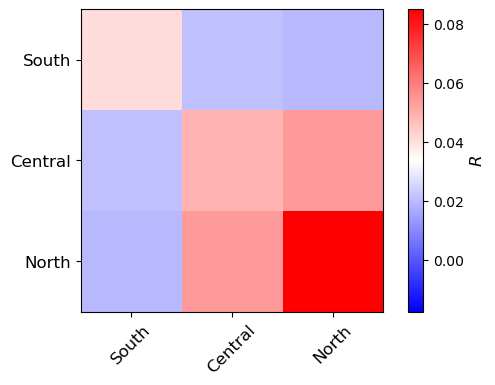

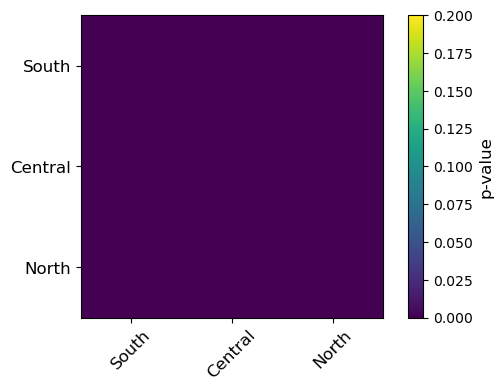

In [18]:
#Define category to define populations
category_label = 'region'
#List of populations used in this category
categories = ['South', 'Central', 'North']
#Definition of thresholds to define related pairs
max_p = .05
min_IBD = 0.1

#We calculate the fraction of related pairs across populations, their p-value of deviation with respect to the
#fraction overall paris, and the overall fraction.
ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories, \
                                                                                     verbose = True, perm_pval = False)
#Parameters to define if we want to save the figure produced
save_as = None
#save_as = save_path + "ibd_regions.png"
#Show the results
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, ibdfrac_pval_per_cat, min_IBD = min_IBD, max_p = max_p, \
                     save_as = save_as, cmap_label = r"$R$", subplot_adj=[None, None, None, .25])

And we repeat the same but mergint central with north regions:

Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


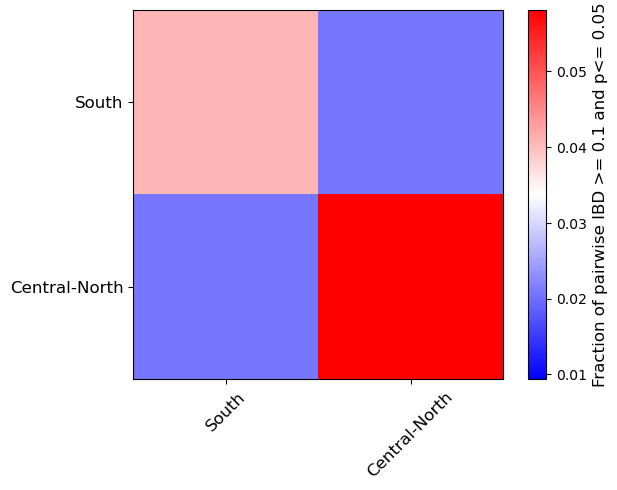

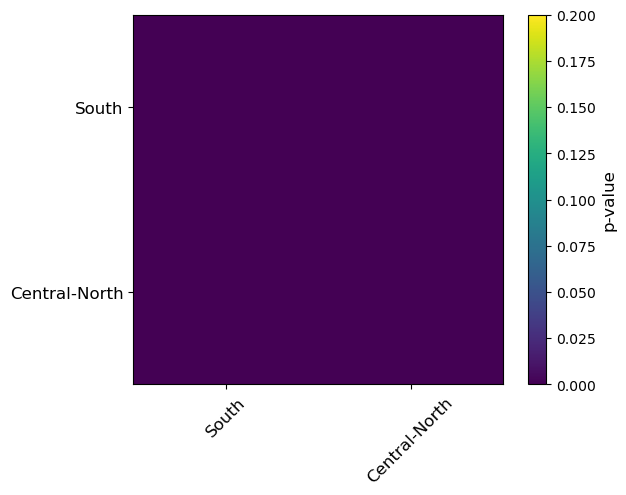

In [19]:
#Defining variable regionSN
ibd_res_meta['regionSN'] = pd.Series()
ibd_res_meta.loc[ibd_res_meta['province'] == 'Maputo City', 'regionSN'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Maputo', 'regionSN'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Inhambane', 'regionSN'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Manica', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Sofala', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Tete', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Zambezia', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Nampula', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Niassa', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Cabo Delgado', 'regionSN'] = 'Central-North'
ibd_pval_meta['regionSN'] = ibd_res_meta['regionSN']

#Define category to define populations
category_label = 'regionSN'
#List of populations used in this category
categories = ['South', 'Central-North']
#Definition of thresholds to define related pairs
max_p = .05
min_IBD = 0.1

#We calculate the fraction of related pairs across populations, their p-value of deviation with respect to the
#fraction overall paris, and the overall fraction.
ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories, \
                                                                                     verbose = True, perm_pval = False)
#Parameters to define if we want to save the figure produced
save_as = None
#save_as = save_path + "ibd_regions.pdf"
#Show the results
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, ibdfrac_pval_per_cat, min_IBD = min_IBD, max_p = max_p, \
                     save_as = save_as)

## Correlating geographic distance with genetic relatedness

Here we explore the dependence on IBD with the pairwise distance of samples. For this, we use the GPS location of the households, and the one of the health facilities when the first was not available. 

In [16]:
#Calculating pariwise distance matrix
x, y = np.array(ibd_res_meta['longitude'], dtype = float), np.array(ibd_res_meta['latitude'], dtype = float)
dist_matrix = clustering.all_distances(x, y, x, y)
x, y = np.array(ibd_res_meta['longitude_us'], dtype = float), np.array(ibd_res_meta['latitude_us'], dtype = float)
dist_matrix_us = clustering.all_distances(x, y, x, y)

for i in range(dist_matrix.shape[0]):
    for j in range(dist_matrix.shape[1]):
        if np.isnan(dist_matrix[i,j]):
            dist_matrix[i,j] = dist_matrix_us[i,j]
            
#Define arrays with IBD results and their sample distances
ibd_mat = np.array(ibd_res)
p_mat = np.array(ibd_pval)
ibd_values = ibd_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
p_values = p_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
dist_values = dist_matrix[np.isfinite(ibd_mat)&np.isfinite(p_mat)]

We finally conduct an analysis of the dependence of genetic relatedness on the geographical distance across pairs. We analyse this dependence at three spatial scales: 

- From 100 km to 1400 km
- From 10 km to 100 km
- From 0 to 10 km

For each case, we define a number of spatial bins balancing sample size with spatial granularity, and we estimate the relatedness in each bin as the fraction of related pairs whose distance between them is within the corresponding bin. 
We use three different thresholds in IBD to compare the consistency of trends. We finally obtain the statistical significance of the  relationship from logistic regression analysis. 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               286246
Model:                            GLM   Df Residuals:                   286244
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24343.
Date:                Tue, 19 Nov 2024   Deviance:                       48685.
Time:                        12:17:52   Pearson chi2:                 2.89e+05
No. Iterations:                     8   Pseudo R-squ. (CS):           0.002579
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2774      0.030   -107.513      0.0

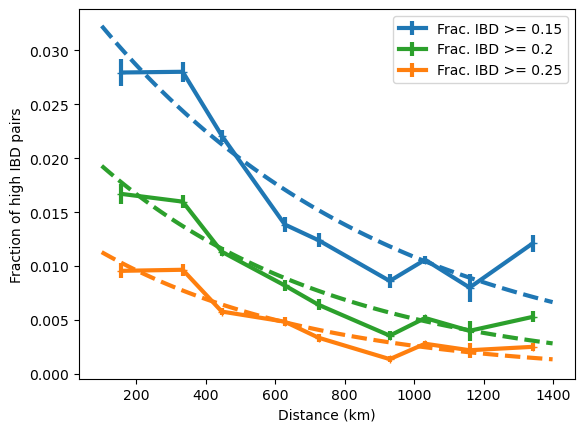

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                54127
Model:                            GLM   Df Residuals:                    54125
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6418.4
Date:                Tue, 19 Nov 2024   Deviance:                       12837.
Time:                        12:17:57   Pearson chi2:                 5.41e+04
No. Iterations:                     7   Pseudo R-squ. (CS):          4.328e-06
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6701      0.059    -62.373      0.0

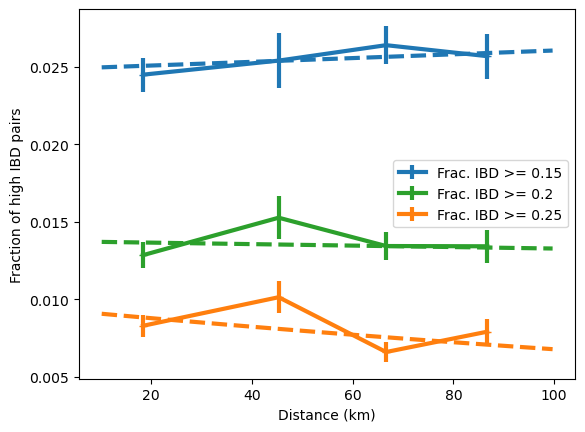

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                17498
Model:                            GLM   Df Residuals:                    17496
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3430.6
Date:                Tue, 19 Nov 2024   Deviance:                       6861.2
Time:                        12:17:58   Pearson chi2:                 1.75e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001239
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9054      0.036    -80.341      0.0

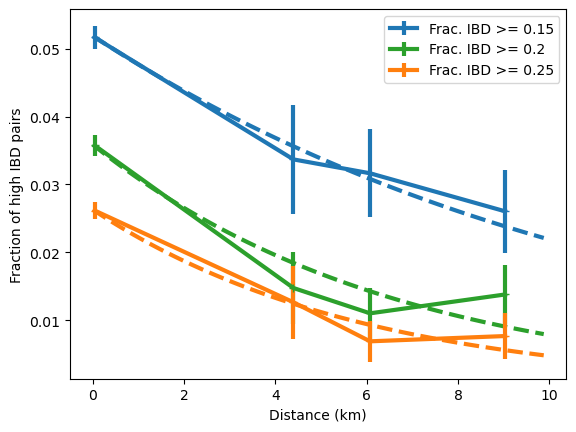

In [18]:
#IBD thresholds and their colours
ibd_thresholds = [.15, .2, .25]
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:grey']

#Defining bins and distance ranges
nbins = 10
min_dist = 100
max_dist = 1400
#Number of random runs used for error bars
nrands = 500

#Calculating IBD versus distance and showing results
for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

#Defining bins and distance ranges
nbins = 5
min_dist = 10
max_dist = 100

#Calculating IBD versus distance and showing results
for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

#Defining bins and distance ranges
nbins = 5
min_dist = 0
max_dist = 10

#Calculating IBD versus distance and showing results
for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()